In [2]:
import shutil
from IPython import get_ipython

if shutil.which("nvidia-smi") is not None:
    get_ipython().system("nvidia-smi")
else:
    print("No NVIDIA GPU or driver detected.")

Mon Apr 28 19:37:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              2W /   40W |      83MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
# --- Device Setup --- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids = list(range(torch.cuda.device_count()))
print(f"Using device: {device}")
print(f"Device IDs: {device_ids}")

Using device: cuda:0
Device IDs: [0]


In [5]:
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes")
    print(f"GPU Memory Allocated (Total): {torch.cuda.memory_allocated()} bytes")

Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes
GPU Memory Allocated (Total): 0 bytes


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.init import _calculate_fan_in_and_fan_out
from timm.layers import to_2tuple, trunc_normal_
import os
import torchvision.utils as utils
import torch.utils.data as data
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.models import vgg16
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from random import randrange
import time
from math import log10
from skimage import measure
import ipywidgets as widgets
from IPython.display import display
from torch.nn.init import trunc_normal_
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF


In [7]:
from torchvision import transforms

# Model

### RevisedLayerNorm

In [8]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [9]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [10]:

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


(torch.Size([2, 64, 16, 16]),
 torch.Size([32, 16, 64]),
 torch.Size([2, 16, 16, 64]),
 True)

### LocalWindowAttention

In [11]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output


#### compute_log_relative_positions

In [12]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


### AdaptiveAttention

In [13]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          self.shift_size, (self.window_size - self.shift_size + pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')
        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Reverse the cyclic shift
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), self.shift_size:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output

### VisionTransformerBlock

In [14]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x

### PatchEmbedding and PatchReconstruction

In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


### SelectiveKernelFusion

In [16]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


### TransformerStage

In [17]:
class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


## DehazingTransformer

In [18]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

#### build_dehazing_transformer

In [19]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

## ConvolutionalGuidedFilter

In [20]:
class ConvolutionalGuidedFilter(nn.Module):
    def __init__(self, radius=1, norm_layer=nn.BatchNorm2d, conv_kernel_size: int = 1):
        super(ConvolutionalGuidedFilter, self).__init__()

        self.box_filter = nn.Conv2d(
            3, 3, kernel_size=3, padding=radius, dilation=radius, bias=False, groups=3
        )
        self.conv_a = nn.Sequential(
            nn.Conv2d(
                6,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                3,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
        )
        self.box_filter.weight.data[...] = 1.0

    def forward(self, x_low_res, y_low_res, x_high_res):
        _, _, h_lr, w_lr = x_low_res.size()
        _, _, h_hr, w_hr = x_high_res.size()

        N = self.box_filter(x_low_res.data.new().resize_((1, 3, h_lr, w_lr)).fill_(1.0))
        ## mean_x
        mean_x = self.box_filter(x_low_res) / N
        ## mean_y
        mean_y = self.box_filter(y_low_res) / N
        ## cov_xy
        cov_xy = self.box_filter(x_low_res * y_low_res) / N - mean_x * mean_y
        ## var_x
        var_x = self.box_filter(x_low_res * x_low_res) / N - mean_x * mean_x

        ## A
        A = self.conv_a(torch.cat([cov_xy, var_x], dim=1))
        ## b
        b = mean_y - A * mean_x

        ## mean_A; mean_b
        mean_A = F.interpolate(A, (h_hr, w_hr), mode="bilinear", align_corners=True)
        mean_b = F.interpolate(b, (h_hr, w_hr), mode="bilinear", align_corners=True)

        return mean_A * x_high_res + mean_b

## PixelAttentionLayer and ChannelAttentionLayer

In [21]:
class PixelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(PixelAttentionLayer, self).__init__()
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, 1, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(ChannelAttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.avg_pool(x)
        attention_map = self.attention(pooled)
        return x * attention_map


## HybridResidualDenseBlock

In [22]:
class HybridResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_dense_layers=4):
        super().__init__()
        self.layers = nn.ModuleList()
        self.growth_rate = growth_rate
        self.in_channels = in_channels
        total_channels = in_channels

        for i in range(num_dense_layers):
            self.layers.append(
                nn.Conv2d(total_channels, growth_rate, kernel_size=3, padding=2**i, dilation=2**i)
            )
            total_channels += growth_rate

        self.fusion = nn.Conv2d(total_channels, in_channels, kernel_size=1)
        self.channel_attention = ChannelAttentionLayer(in_channels)
        self.pixel_attention = PixelAttentionLayer(in_channels)

        # Gated residual fusion
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = [x]
        for conv in self.layers:
            out = F.relu(conv(torch.cat(features, dim=1)))
            features.append(out)

        dense_out = torch.cat(features, dim=1)
        fused = self.fusion(dense_out)
        ca = self.channel_attention(fused)
        pa = self.pixel_attention(ca)

        gate_input = torch.cat([x, pa], dim=1)
        gated_fusion = self.gate(gate_input)
        return x * (1 - gated_fusion) + pa * gated_fusion

## AdaptiveInstanceNormalization

In [23]:
class AdaptiveInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(AdaptiveInstanceNormalization, self).__init__()

        # Learnable scaling factors
        self.scale_x = nn.Parameter(torch.tensor(1.0))  # Identity scaling
        self.scale_norm = nn.Parameter(torch.tensor(0.0))  # Initially no effect

        # Instance normalization layer with affine transformation enabled
        self.instance_norm = nn.InstanceNorm2d(num_channels, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        normalized_x = self.instance_norm(x)
        return self.scale_x * x + self.scale_norm * normalized_x

## DEEPGUIDEDNETWORK

In [ ]:
class DeepGuidedNetwork(nn.Module):
    def __init__(self, in_channels=3, radius=1):
        super().__init__()
        self.in_channels = in_channels
        norm = AdaptiveInstanceNormalization  # define this separately if used
        kernel_size = 3
        depth_rate = 64
        growth_rate = 16
        num_dense_layer = 4

        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=1)
        self.conv_out = nn.Conv2d(depth_rate, depth_rate, kernel_size=kernel_size, padding=1)

        self.rdb1 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb2 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb3 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)
        self.rdb4 = HybridResidualDenseBlock(depth_rate, growth_rate, num_dense_layer)

        # Modified tail for x2 upscaling
        self.tail = nn.Sequential(
            nn.Conv2d(depth_rate, 256, 3, padding=1),  # 64 → 256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, in_channels * 4, 3, padding=1),  # 256 → 12 (for 2× upscaling)
            nn.PixelShuffle(2)
        )


    def forward(self, x, sr=False):
        x_in = self.conv_in(x)
        feat1 = self.rdb1(x_in)
        feat2 = self.rdb2(feat1)
        feat3 = self.rdb3(feat2)
        feat4 = self.rdb4(feat3)
        out_feat = self.conv_out(feat4)

        sr = self.tail(out_feat)  # shape: (B, 3, H×2, W×2)
        return sr, sr, [feat1, feat2, feat3, feat4]


In [25]:
# Create a random input tensor
input_tensor = torch.randn(1, 3, 64, 64)  # Batch size of 1, 3 channels, 256x256 image

# Initialize the DeepGuidedNetwork
model = DeepGuidedNetwork(radius=1)

# Forward pass through the network
output_tensor, dummy_out, features = model(input_tensor)

# Print the output shape
print("Output shape:", output_tensor.shape)
print("Feature shapes:", [f.shape for f in features])

Output shape: torch.Size([1, 3, 256, 256])
Feature shapes: [torch.Size([1, 64, 64, 64]), torch.Size([1, 64, 64, 64]), torch.Size([1, 64, 64, 64]), torch.Size([1, 64, 64, 64])]


In [26]:
teacher_net = DeepGuidedNetwork(radius=1).to(device)
# test teacher output shape
input_tensor = torch.randn(2, 3, 64, 64).to(device)
output_tensor, base_hr, features = teacher_net(input_tensor)
# Check output shape
output_shape = output_tensor.shape
base_hr_shape = base_hr.shape
features_shape = [feat.shape for feat in features]
print("Output shape:", output_shape)
print("Base HR shape:", base_hr_shape)
print("Features shape:", features_shape)

Output shape: torch.Size([2, 3, 256, 256])
Base HR shape: torch.Size([2, 3, 256, 256])
Features shape: [torch.Size([2, 64, 64, 64]), torch.Size([2, 64, 64, 64]), torch.Size([2, 64, 64, 64]), torch.Size([2, 64, 64, 64])]


In [27]:
# test to_psnr
# to_psnr(input_tensor, output_tensor)

## Validation

### PSNR

In [28]:
def to_psnr(dehaze, gt):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio) between dehazed and ground truth images.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: PSNR values for each image in the batch.
    """
    # print("Shapes: ", dehaze.shape, gt.shape)
    mse = F.mse_loss(dehaze, gt, reduction='none').mean(dim=[1, 2, 3])  # Compute MSE per image
    intensity_max = 1.0

    # Compute PSNR safely, avoiding division by zero and extreme values
    psnr_list = [10.0 * log10(intensity_max / max(mse_val.item(), 1e-6)) for mse_val in mse]

    return psnr_list


### SSIM

In [29]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='none')

def to_ssim(dehaze: torch.Tensor, gt: torch.Tensor):
    """
    Compute SSIM directly on the GPU using torchmetrics.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: SSIM values for each image in the batch.
    """
    ssim_values = ssim_metric(dehaze, gt)  # Shape: [B]
    # print("1",ssim_values)
    # print("2",[ssim_values])
    ssim_values = ssim_values.tolist() 
    # print(type(ssim_values))
    if isinstance(ssim_values, float):  # Correct way to check for a float
        return [ssim_values]  # Convert single float to a list
    return ssim_values  # Otherwise, return as is


In [30]:
# Test with a dummy tensor
dehaze = torch.rand(1, 3, 360, 360)  # Random batch of images
gt = torch.rand(1, 3, 360, 360)  # Random ground truth images

ssim_scores = to_ssim(dehaze, gt)
print(ssim_scores)  # Should print a list of 6 SSIM values

[0.009152994491159916]


### Validation Haze

In [31]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        # print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        # print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim


### Validation SR

In [32]:
def validation_sr(net, sr_val_loader, device):
    psnr_list = []
    ssim_list = []
    for lr, hr in sr_val_loader:
        with torch.no_grad():
            lr, hr = lr.to(device), hr.to(device)
            sr_out, _, _ = net(lr, sr = False)
        # print("Shapes 1: ", sr_out.shape, hr.shape)
        psnr_list.extend(to_psnr(sr_out, hr))
        ssim_list.extend(to_ssim(sr_out, hr))

    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0
    return avr_psnr, avr_ssim


### test

In [33]:
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)

In [34]:
# psnr, ssim = validationB(net, val_data_loader, device, category)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # psnr, ssim = validationB(model, val_loader, device, "indoor", save_tag=True)
# print(f"Validation PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")


## Widgets

In [35]:
execution_env_widget = widgets.Dropdown(options=['local', 'kaggle'], value='local', description='Execution Env:')
display(execution_env_widget)

if os.path.exists('/kaggle'):
    execution_env_widget.value = 'kaggle' 

Dropdown(description='Execution Env:', options=('local', 'kaggle'), value='local')

In [36]:

# --- Create widgets for each hyper-parameter ---
learning_rate_widget = widgets.FloatText(value=1e-4, description='Learning Rate:')
crop_size_widget = widgets.Text(value='128,128', description='Crop Size:')
train_batch_size_widget = widgets.IntText(value=2, description='Train Batch Size:')
version_widget = widgets.IntText(value=0, description='Version:')
growth_rate_widget = widgets.IntText(value=16, description='Growth Rate:')
lambda_loss_widget = widgets.FloatText(value=0.04, description='Lambda Loss:')
val_batch_size_widget = widgets.IntText(value=2, description='Val Batch Size:')
category_widget = widgets.Dropdown(options=['indoor', 'outdoor', 'reside', 'nh'], value='reside', description='Category:')

# --- Display the widgets ---
display(
    learning_rate_widget, crop_size_widget, train_batch_size_widget, version_widget,
    growth_rate_widget, lambda_loss_widget, 
    val_batch_size_widget, category_widget
)

# --- Function to parse crop size ---
def parse_crop_size(crop_size_str):
    return [int(x) for x in crop_size_str.split(',')]

# --- Assign the widget values to variables ---
learning_rate = learning_rate_widget.value
crop_size = parse_crop_size(crop_size_widget.value)
train_batch_size = train_batch_size_widget.value
version = version_widget.value
growth_rate = growth_rate_widget.value
lambda_loss = lambda_loss_widget.value
val_batch_size = val_batch_size_widget.value
category = category_widget.value

execution_env = execution_env_widget.value  # Local or Kaggle


print('\nHyper-parameters set:')
print(f'learning_rate: {learning_rate}')
print(f'crop_size: {crop_size}')
print(f'train_batch_size: {train_batch_size}')
print(f'version: {version}')
print(f'growth_rate: {growth_rate}')
print(f'lambda_loss: {lambda_loss}')
print(f'val_batch_size: {val_batch_size}')
print(f'category: {category}')
print(f'execution_env: {execution_env}')


FloatText(value=0.0001, description='Learning Rate:')

Text(value='128,128', description='Crop Size:')

IntText(value=2, description='Train Batch Size:')

IntText(value=0, description='Version:')

IntText(value=16, description='Growth Rate:')

FloatText(value=0.04, description='Lambda Loss:')

IntText(value=2, description='Val Batch Size:')

Dropdown(description='Category:', index=2, options=('indoor', 'outdoor', 'reside', 'nh'), value='reside')


Hyper-parameters set:
learning_rate: 0.0001
crop_size: [128, 128]
train_batch_size: 2
version: 0
growth_rate: 16
lambda_loss: 0.04
val_batch_size: 2
category: reside
execution_env: local


### Paths Dehaze

In [37]:
# --- Set category-specific hyper-parameters ---
if category == 'indoor':
    num_epochs = 1500
    train_data_dir = './data/train/indoor/'
    val_data_dir = './data/test/SOTS/indoor/'
elif category == 'outdoor':
    num_epochs = 10
    train_data_dir = './data/train/outdoor/'
    val_data_dir = './data/test/SOTS/outdoor/'
elif category == 'reside':
    print('Using RESIDE dataset')
    num_epochs = 200
    # train_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    train_data_dir = '/kaggle/input/reside-processed/kaggle/working/cropped_train'
    val_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    test_data_dir = '/kaggle/input/reside6k/RESIDE-6K/test'
    if execution_env == 'local':
        print('Using local RESIDE dataset')
        train_data_dir = './dataset/reside_processed/kaggle/working/cropped_train'
        # train_data_dir = '/Volumes/S/dev/project/code/Aphase/dehaze/dataset/reside_processed/kaggle/working/cropped_train/'
elif category == 'nh':
    num_epochs = 50
    train_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
    val_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
else:
    raise Exception('Wrong image category. Set it to indoor or outdoor for RESIDE dataset.')

# --- Adjust paths based on execution environment ---
# if execution_env == 'kaggle':
    # train_data_dir = '/kaggle/input/reside-dataset/' + train_data_dir.strip('./')
    # val_data_dir = '/kaggle/input/reside-dataset/' + val_data_dir.strip('./')
    # train_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T'
    # val_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V' 
    # train_data_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
    # val_data_dir = '/kaggle/input/o-haze/O-HAZY/GT' 
print('\nFinal dataset paths:')
print(f'Training directory: {train_data_dir}')
print(f'Validation directory: {val_data_dir}')
print(f'Number of epochs: {num_epochs}')

Using RESIDE dataset
Using local RESIDE dataset

Final dataset paths:
Training directory: ./dataset/reside_processed/kaggle/working/cropped_train
Validation directory: /kaggle/input/reside6k/RESIDE-6K/train
Number of epochs: 200


In [38]:
# num_epochs = 200

In [39]:
# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
hazeeffected_images_dir_train = f"{train_data_dir}/hazy"
hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
hazeeffected_images_dir_valid = f"{val_data_dir}/hazy"
hazefree_images_dir_valid = f"{val_data_dir}/GT"

In [40]:
# # hazeeffected_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
# # hazefree_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
# # hazeeffected_images_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
# # hazefree_images_dir = '/kaggle/input/o-haze/O-HAZY/GT'

# hazeeffected_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN'
# hazefree_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT'
# hazeeffected_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/IN'
# hazefree_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/GT'

### Paths SR

In [ ]:
sr_enabled = True
    # sr_hr_dir = '/kaggle/input/flickr2k/Flickr2K/Flickr2K_HR'
    # sr_lr_dir = '/kaggle/input/flickr2k/Flickr2K/Flickr2K_LR_bicubic/X4'
if sr_enabled:
    sr_hr_dir = '/kaggle/input/sr-flickr/kaggle/working/filtered_HR'
    sr_lr_dir = '/kaggle/input/sr-flickr/kaggle/working/filtered_LR/X4'
    # sr_hr_dir = '/kaggle/input/flickr2k/Flickr2K/Flickr2K_HR'
    # sr_lr_dir = '/kaggle/input/flickr2k/Flickr2K/Flickr2K_LR_bicubic/X4'
    if execution_env == 'local':
        sr_hr_dir = './dataset/Flickr2K/Flickr2K_HR'
        sr_lr_dir = './dataset/Flickr2K/Flickr2K_LR_unknown/X4'
        # sr_hr_dir = './dataset/SR_flickr/kaggle/working/filtered_HR'
        # sr_lr_dir = './dataset/SR_flickr/kaggle/working/filtered_LR/X4'
        # sr_hr_dir = '/Volumes/S/dev/project/code/Aphase/dehaze/dataset/SR_flickr/kaggle/working/filtered_HR'
        # sr_lr_dir = '/Volumes/S/dev/project/code/Aphase/dehaze/dataset/SR_flickr/kaggle/working/filtered_LR/X4'

In [42]:
def print_log(epoch, num_epochs, one_epoch_time, train_psnr, val_psnr, val_ssim, category):
    log_dir = "./training_log"
    os.makedirs(log_dir, exist_ok=True)  # Ensure the directory exists

    log_path = os.path.join(log_dir, f"{category}_log.txt")

    print('({0:.0f}s) Epoch [{1}/{2}], Train_PSNR:{3:.2f}, Val_PSNR:{4:.2f}, Val_SSIM:{5:.4f}'
          .format(one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim))

    # --- Write the training log --- #
    with open(log_path, 'a') as f:
        print('Date: {0}, Time_Cost: {1:.0f}s, Epoch: [{2}/{3}], Train_PSNR: {4:.2f}, Val_PSNR: {5:.2f}, Val_SSIM: {6:.4f}'
              .format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                      one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim), file=f)

In [43]:
# def adjust_learning_rate(optimizer, epoch, category, lr_decay=0.90):
#     """
#     Adjusts the learning rate based on the epoch and dataset category.

#     :param optimizer: The optimizer (e.g., Adam, SGD).
#     :param epoch: Current epoch number.
#     :param category: Dataset category ('indoor', 'outdoor', or 'NH').
#     :param lr_decay: Multiplicative factor for learning rate decay.
#     """
#     # Define learning rate decay steps based on category
#     step_dict = {'indoor': 18, 'outdoor': 3, 'NH': 20}
#     step = step_dict.get(category, 3)  # Default step size if category is unknown

#     # Decay learning rate at the specified step
#     if epoch > 0 and epoch % step == 0:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= lr_decay
#             print(f"Epoch {epoch}: Learning rate adjusted to {param_group['lr']:.6f}")


## Perceptual Loss

In [44]:
# --- Perceptual Feature Loss Network --- #
class PerceptualLossNet(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        self.feature_extractor = vgg_model
        self.feature_layers = {'3': "low_level", '8': "mid_level", '15': "high_level"}

    def get_feature_maps(self, x):
        feature_maps = []
        for layer_id, layer in self.feature_extractor.named_children():
            x = layer(x)
            if layer_id in self.feature_layers:
                feature_maps.append(x)
        return feature_maps

    def forward(self, predicted, target):
        pred_features = self.get_feature_maps(predicted)
        target_features = self.get_feature_maps(target)
        
        # Compute perceptual loss as mean squared error across feature maps
        loss = torch.stack([F.mse_loss(p, t) for p, t in zip(pred_features, target_features)]).mean()
        
        return loss

class SSFM(nn.Module):
    def __init__(self, loss_type='l1'):
        super(SSFM, self).__init__()
        assert loss_type in ['l1', 'l2'], "loss_type must be 'l1' or 'l2'"
        self.loss_type = loss_type

    def forward(self, student_feats, teacher_feats):
        """
        student_feats: List of feature maps from student RDBs [rdb1, rdb2, rdb3, rdb4]
        teacher_feats: List of corresponding feature maps from teacher
        """
        assert len(student_feats) == len(teacher_feats), "Feature lists must match"

        total_loss = 0.0
        for s_feat, t_feat in zip(student_feats, teacher_feats):
            # Match resolution
            if s_feat.shape != t_feat.shape:
                t_feat = F.interpolate(t_feat, size=s_feat.shape[2:], mode='bilinear', align_corners=False)
            
            if self.loss_type == 'l1':
                loss = F.l1_loss(s_feat, t_feat)
            else:
                loss = F.mse_loss(s_feat, t_feat)
            
            total_loss += loss

        return total_loss / len(student_feats)


In [45]:
from torchvision.models import vgg16


# --- Initialize Model --- #
net = DeepGuidedNetwork().to(device)

# --- Enable Multi-GPU (if available) --- #
if len(device_ids) > 1:
    net = nn.DataParallel(net, device_ids=device_ids)

# --- Optimizer --- #
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# --- Load Pretrained VGG16 for Perceptual Loss --- #
vgg_features = vgg16(pretrained=True).features[:16].to(device)
for param in vgg_features.parameters():
    param.requires_grad = False

loss_network = PerceptualLossNet(vgg_features)
loss_network.eval()

# --- Load Model Weights (if available) --- #
checkpoint_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth" 

try:
    net.load_state_dict(torch.load(checkpoint_path, weights_only=False, map_location=torch.device('cpu')))
    print(f"✅ Model weights loaded from {checkpoint_path}")
except FileNotFoundError:
    print(f"⚠️ No pretrained weights found at {checkpoint_path}")

# --- Compute Total Trainable Parameters --- #
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"📊 Total Trainable Parameters: {total_params:,}")

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚠️ No pretrained weights found at /kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth
📊 Total Trainable Parameters: 572,628


In [46]:


class FeatureAffinityModule(nn.Module):
    def __init__(self, channels):
        super(FeatureAffinityModule, self).__init__()
        self.channels = channels

    def forward(self, student_features, teacher_features):
        # Debug: Print input shapes
        # print("Input student_features shape:", student_features.shape)
        # print("Input teacher_features shape:", teacher_features.shape)

        # # Normalize features
        # print("\nBefore normalization:")
        # print("Student features:", student_features.shape)  # Example for the first feature of the first batch
        # print("Teacher features:", teacher_features.shape)  # Example for the first feature of the first batch

        student_norm = F.normalize(student_features.view(student_features.size(0), self.channels, -1), dim=2)
        # print("Student normalized features:", student_norm.shape)  # Checking first normalized value

        # print("\nother:")
        # print("student_features.size(0)",student_features.size(0))
        # print("teacher_features.size(0)",teacher_features.size(0))
        # print("self.channels",self.channels)
        # print("student_features.view(student_features.size(0), self.channels, -1)",student_features.view(student_features.size(0), self.channels, -1).shape)
        # print("teacher_features.view(teacher_features.size(0), self.channels, -1)",teacher_features.view(teacher_features.size(0), self.channels, -1).shape)
        
        teacher_norm = F.normalize(teacher_features.view(teacher_features.size(0), self.channels, -1), dim=2)
        # print("Teacher normalized features:", teacher_norm[0, 0, :2])  # Checking first normalized value

        # Compute affinity matrices
        student_affinity = torch.bmm(student_norm, student_norm.transpose(1, 2))
        teacher_affinity = torch.bmm(teacher_norm, teacher_norm.transpose(1, 2))

        # Debug: Print affinity matrix shapes
        # print("\nStudent affinity matrix shape:", student_affinity.shape)
        # print("Teacher affinity matrix shape:", teacher_affinity.shape)

        # Compute KL divergence
        loss = F.kl_div(F.log_softmax(student_affinity, dim=-1),
                        F.softmax(teacher_affinity, dim=-1),
                        reduction='batchmean')

        # Debug: Print computed loss
        # print("\nComputed loss:", loss.item())

        return loss


In [47]:
# ..

# Datasets

## Haze Dataset

In [48]:
import random
class HazeDataset(Dataset):
    def __init__(self, hazeeffected_images_dir, hazefree_images_dir, split="train", split_ratio=(0.8, 0.1, 0.1), random_seed=42):
        """
        Dataset class for handling hazy and corresponding ground-truth images (already aligned and cropped).

        Args:
            hazeeffected_images_dir (str): Directory for hazy images.
            hazefree_images_dir (str): Directory for ground-truth images.
            split (str): "train", "valid", or "test" (determines data split).
            split_ratio (tuple): A tuple of three floats representing the train, validation, and test splits.
                                 (default 80% train, 10% validation, 10% test).
            random_seed (int): Random seed for reproducibility in shuffling data.
        """
        super().__init__()

        if sum(split_ratio) != 1.0:
            raise ValueError("The sum of split_ratio must be 1.0")

        self.train_ratio, self.valid_ratio, self.test_ratio = split_ratio

        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        # print("Haze affected images dir: ", hazeeffected_images_dir)
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        hazy_data.sort()

        # Shuffle the dataset for randomization
        random.seed(random_seed)
        random.shuffle(hazy_data)

        # Split dataset based on provided ratios
        total_images = len(hazy_data)
        train_size = int(total_images * self.train_ratio)
        valid_size = int(total_images * self.valid_ratio)
        test_size = total_images - train_size - valid_size

        if split == "train":
            hazy_data = hazy_data[:train_size]
        elif split == "valid":
            hazy_data = hazy_data[train_size:train_size+valid_size]
        elif split == "test":
            hazy_data = hazy_data[train_size+valid_size:]
        else:
            raise ValueError(f"Invalid split value: {split}. Choose from ['train', 'valid', 'test'].")

        self.haze_names = []
        self.gt_names = []

        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(hazeeffected_images_dir, filename)
            gt_path = os.path.join(hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        # Define transforms
        self.transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.transform_gt = Compose([ToTensor()])

    def get_images(self, index):
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        haze = self.transform_haze(haze_img)
        gt = self.transform_gt(gt_img)

        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)

### Haze DataLoader

In [49]:
# For training:
train_dataset = HazeDataset(hazeeffected_images_dir=hazeeffected_images_dir_train, 
                             hazefree_images_dir=hazefree_images_dir_train, 
                             split="train", 
                             split_ratio=(0.8, 0.1, 0.1))

# For validation:
val_dataset = HazeDataset(hazeeffected_images_dir=hazeeffected_images_dir_train, 
                             hazefree_images_dir=hazefree_images_dir_train, 
                             split="valid", 
                             split_ratio=(0.8, 0.1, 0.1))

# For testing:
test_dataset = HazeDataset(hazeeffected_images_dir=hazeeffected_images_dir_train, 
                            hazefree_images_dir=hazefree_images_dir_train, 
                            split="test", 
                            split_ratio=(0.8, 0.1, 0.1))


In [50]:
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 4800, Validation samples: 600, Test samples: 600


In [51]:
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)

In [52]:
# len(glob.glob( "/kaggle/working/cropped_train/hazy/*")), len(glob.glob("/kaggle/working/cropped_train/GT/*"))

## SR Dataset

In [53]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, scale='x4', split='train', split_ratio=(0.8, 0.1, 0.1), random_seed=42):
        """
        Super-Resolution dataset that matches LR and HR image pairs based on naming pattern.
        Assumes images are already aligned and correctly scaled. No cropping is applied.

        Args:
            lr_dir (str): Directory containing low-resolution images (e.g., x2, x3, x4).
            hr_dir (str): Directory containing high-resolution images.
            scale (str): Scale suffix in LR filenames (e.g., 'x2', 'x3', 'x4').
            split (str): 'train', 'val', or 'test' (determines data split).
            split_ratio (tuple): A tuple of three floats representing the train, validation, and test splits.
                                 (default 80% train, 10% validation, 10% test).
            random_seed (int): Random seed for reproducibility in shuffling data.
        """
        super().__init__()

        if sum(split_ratio) != 1.0:
            raise ValueError("The sum of split_ratio must be 1.0")

        self.train_ratio, self.valid_ratio, self.test_ratio = split_ratio

        valid_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        lr_images = sorted([
            f for f in glob.glob(os.path.join(lr_dir, "*.*"))
            if f.lower().endswith(valid_ext)
        ])

        lr_hr_pairs = []
        for lr_path in lr_images:
            lr_name = os.path.basename(lr_path)
            hr_name = lr_name.replace(scale, '')  # assumes naming like image_x4.png -> image.png
            hr_path = os.path.join(hr_dir, hr_name)

            if not os.path.exists(hr_path):
                print(f"Warning: Ground-truth missing for {lr_name}, skipping.")
                continue

            lr_hr_pairs.append((lr_path, hr_path))

        if not lr_hr_pairs:
            raise ValueError("No matching LR-HR image pairs found.")

        # Shuffle the dataset for randomization
        random.seed(random_seed)
        random.shuffle(lr_hr_pairs)

        # Split dataset based on provided ratios
        total_pairs = len(lr_hr_pairs)
        train_size = int(total_pairs * self.train_ratio)
        valid_size = int(total_pairs * self.valid_ratio)
        test_size = total_pairs - train_size - valid_size

        # Splitting the data based on the chosen split
        if split == 'train':
            self.lr_hr_pairs = lr_hr_pairs[:train_size]
        elif split == 'val':
            self.lr_hr_pairs = lr_hr_pairs[train_size:train_size+valid_size]
        elif split == 'test':
            self.lr_hr_pairs = lr_hr_pairs[train_size+valid_size:]
        else:
            raise ValueError("split must be either 'train', 'val', or 'test'")

        # Define common transform
        self.transform = Compose([ToTensor()])

    def __len__(self):
        return len(self.lr_hr_pairs)

    def __getitem__(self, idx):
        lr_path, hr_path = self.lr_hr_pairs[idx]

        try:
            lr_img = Image.open(lr_path).convert('RGB')
            hr_img = Image.open(hr_path).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Unidentified image at {lr_path} or {hr_path}")

        lr_tensor = self.transform(lr_img)
        hr_tensor = self.transform(hr_img)

        if lr_tensor.shape[0] != 3 or hr_tensor.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {lr_path}")

        return lr_tensor, hr_tensor

### SR DataLoader

In [54]:

# def custom_collate_fn(batch):
#     min_height = min([x[0].shape[1] for x in batch])
#     min_width = min([x[0].shape[2] for x in batch])
#     resized_batch = [(TF.resize(x[0], [min_height, min_width]), TF.resize(x[1], [min_height, min_width])) for x in batch]
#     return torch.utils.data.dataloader.default_collate(resized_batch)

import torch
import torchvision.transforms.functional as TF

def custom_collate_fn(batch):
    # Assumes each item in batch is a tuple: (input_tensor, gt_tensor)
    # Input is already 64x64, ground truth is 256x256
    resized_batch = []
    for input_tensor, gt_tensor in batch:
        # Keep input as-is, downsample ground truth to 64x64
        resized_gt = TF.resize(gt_tensor, [64, 64], interpolation=TF.InterpolationMode.NEAREST)
        resized_batch.append((input_tensor, resized_gt))
    return torch.utils.data.dataloader.default_collate(resized_batch)


In [55]:
# --- SR Dataset Setup --- #

if sr_enabled:

    # Dataset for Super-Resolution (SR) task
    # For training:
    sr_train_dataset = SRDataset(lr_dir=sr_lr_dir, 
                            hr_dir=sr_hr_dir,
                            scale="x4", 
                            split="train", 
                            split_ratio=(0.8, 0.1, 0.1))

    # For validation:
    sr_val_dataset = SRDataset(lr_dir=sr_lr_dir, 
                            hr_dir=sr_hr_dir, 
                            scale="x4", 
                            split="val", 
                            split_ratio=(0.8, 0.1, 0.1))

    # For testing:
    sr_test_dataset = SRDataset(lr_dir=sr_lr_dir, 
                            hr_dir=sr_hr_dir, 
                            scale="x4", 
                            split="test", 
                            split_ratio=(0.8, 0.1, 0.1))
    
    # DataLoader for training with drop_last=True to avoid smaller batches
    sr_train_loader = DataLoader(
        sr_train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        # collate_fn=custom_collate_fn,
        drop_last=True  # Ensure the final batch is dropped if not full
    )
    
    # DataLoader for validation with drop_last=True for consistency (optional)
    sr_val_loader = DataLoader(
        sr_val_dataset,
        batch_size=val_batch_size,
        shuffle=False,  # Don't shuffle the validation set
        # collate_fn=custom_collate_fn,
        drop_last=True  # Optional: consider it for consistency across train/val
    )

    # DataLoader for testing (No shuffling and no drop_last)
    sr_test_loader = DataLoader(
        sr_test_dataset,
        batch_size=val_batch_size,  # Define your test batch size
        shuffle=False,  # No shuffling needed for testing
        # collate_fn=custom_collate_fn,  # Use custom collate function if needed
        drop_last=False  # We typically do not drop the last batch for testing
    )

    # Create an iterator for the training set
    sr_iter = iter(sr_train_loader)

In [56]:
print(f"SR Train samples: {len(sr_train_dataset)}, SR Validation samples: {len(sr_val_dataset)}, SR Test samples: {len(sr_test_dataset)}")

SR Train samples: 2120, SR Validation samples: 265, SR Test samples: 265


In [57]:
for i,o in train_data_loader:
    print(i.shape, o.shape)
    break

torch.Size([2, 3, 64, 64]) torch.Size([2, 3, 64, 64])


In [58]:
for i,o in val_data_loader:
    print(i.shape, o.shape)
    break

torch.Size([2, 3, 64, 64]) torch.Size([2, 3, 64, 64])


In [59]:
for i,o in sr_train_loader:
    print(i.shape, o.shape)
    break

torch.Size([2, 3, 64, 64]) torch.Size([2, 3, 256, 256])


In [60]:
for i,o in sr_val_loader:
    print(i.shape, o.shape)
    break

torch.Size([2, 3, 64, 64]) torch.Size([2, 3, 256, 256])


In [61]:
len(sr_train_dataset), len(sr_val_dataset)

(2120, 265)

In [62]:
# enumerate
for i, (lr, hr) in enumerate(sr_train_loader):
    print(f"Batch {i}: LR shape: {lr.shape}, HR shape: {hr.shape}")
    if i == 4:  # Just to limit the output
        break


Batch 0: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])
Batch 1: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])
Batch 2: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])
Batch 3: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])
Batch 4: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


# Init Valid

In [63]:
# --- Teacher Network --- #
teacher_net = DeepGuidedNetwork(radius=1).to(device)
# teacher_net.load_state_dict(torch.load('teacher_model.pth'))
# teacher_net.eval()

# --- Feature Affinity Module --- #
fam = FeatureAffinityModule(channels=16).to(device)
ssfm_loss = SSFM(loss_type='l1') 


# --- Initial Validation --- #
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)
# print(f"[Dehazing Init Val] PSNR: {old_val_psnr:.2f}, SSIM: {old_val_ssim:.4f}")
if sr_enabled:
    sr_val_psnr, sr_val_ssim = validation_sr(net, sr_val_loader, device)
    print(f"[SR Init Val] PSNR: {sr_val_psnr:.2f}, SSIM: {sr_val_ssim:.4f}")

# --- Training Loop --- #
# best_psnr = old_val_psnr
best_psnr = sr_val_psnr
train_psnr_prev = 0
distillation_weight = 1

[SR Init Val] PSNR: 6.60, SSIM: 0.0095


# Train

In [64]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create a directory for TensorBoard logs
log_dir = "runs/sr_training_logs"
os.makedirs(log_dir, exist_ok=True)

# TensorBoard writer
writer = SummaryWriter(log_dir)

global_iter = 0
total_start_time = time.time()

# Optimizer for net and teacher_net (joint training)
optimizer = torch.optim.Adam(list(net.parameters()) + list(teacher_net.parameters()), lr=learning_rate)

# LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    psnr_list = []

    net.train()
    teacher_net.train()

    sr_loader_tqdm = tqdm(sr_train_loader, desc=f"[SR Epoch {epoch+1}/{num_epochs}]", leave=False)

    for batch_id, (sr_lr, sr_hr) in enumerate(sr_loader_tqdm):
        sr_lr, sr_hr = sr_lr.to(device), sr_hr.to(device)
        optimizer.zero_grad()

        # Forward pass through teacher_net for SR
        sr_out, _, t = teacher_net(sr_lr)

        # SR reconstruction loss
        sr_loss = F.l1_loss(sr_out, sr_hr)
        total_loss = sr_loss

        # Optional: forward pass through net (student) for distillation
        with torch.no_grad():
            haze_like_input = sr_lr  # simulate student input for distillation if applicable
            dehaze, base, s = net(haze_like_input)
            distillation_loss = fam(dehaze, sr_out)
            s_loss = ssfm_loss(s, t)
            total_loss += distillation_loss + s_loss

        total_loss.backward()
        optimizer.step()

        psnr_list.extend(to_psnr(sr_out, sr_hr))
        sr_loader_tqdm.set_postfix(loss=total_loss.item(), iter=global_iter)

        # TensorBoard logging (per iteration)
        writer.add_scalar("Loss/Total", total_loss.item(), global_iter)
        writer.add_scalar("Loss/SR", sr_loss.item(), global_iter)
        if 'distillation_loss' in locals():
            writer.add_scalar("Loss/Distillation", distillation_loss.item(), global_iter)
        if 's_loss' in locals():
            writer.add_scalar("Loss/Structure", s_loss.item(), global_iter)

        global_iter += 1

    train_psnr = sum(psnr_list) / len(psnr_list)

    # Save model every 5 epochs
    if epoch % 5 == 0:
        torch.save(teacher_net.state_dict(), f"teacher_net_sr_iter_{epoch}.pth")
        print(f"Model - teacher_net saved at epoch {epoch}.")
        torch.save(net.state_dict(), f"net_sr_iter_{epoch}.pth")
        print(f"Model - net saved at epoch {epoch}.")

    # Validation on SR
    teacher_net.eval()
    sr_val_psnr, sr_val_ssim = validation_sr(net, sr_val_loader, device)
    print(f"[SR Val] PSNR: {sr_val_psnr:.2f}, SSIM: {sr_val_ssim:.4f}")

    # TensorBoard logging (per epoch)
    writer.add_scalar("Metrics/Train_PSNR", train_psnr, epoch)
    writer.add_scalar("Metrics/Val_PSNR", sr_val_psnr, epoch)
    writer.add_scalar("Metrics/Val_SSIM", sr_val_ssim, epoch)

    epoch_duration = time.time() - epoch_start_time
    model_path = f"teacher_net_sr_{version}.pth"
    print_log(epoch + 1, num_epochs, epoch_duration, train_psnr, sr_val_psnr, sr_val_ssim, model_path)

    # Learning rate scheduler based on SR validation PSNR
    scheduler.step(sr_val_psnr)

    # Save best model
    if sr_val_psnr >= best_psnr:
        best_model_path = f"teacher_net_sr_best_{version}.pth"
        torch.save(teacher_net.state_dict(), best_model_path)
        best_psnr = sr_val_psnr

    train_psnr_prev = train_psnr

# Final save
torch.save(teacher_net.state_dict(), f"teacher_net_sr_final_{epoch}.pth")
torch.save(net.state_dict(), f"net_sr_final_{epoch}.pth")
print(f"🏁 SR Training completed in {(time.time() - total_start_time)/60:.2f} minutes.")

# Close the TensorBoard writer
writer.close()

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model - teacher_net saved at epoch 0.
Model - net saved at epoch 0.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(49s) Epoch [1/200], Train_PSNR:18.71, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(44s) Epoch [2/200], Train_PSNR:22.32, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(44s) Epoch [3/200], Train_PSNR:23.21, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(44s) Epoch [4/200], Train_PSNR:23.61, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(42s) Epoch [5/200], Train_PSNR:23.71, Val_PSNR:6.60, Val_SSIM:0.0095


Model - teacher_net saved at epoch 5.
Model - net saved at epoch 5.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(46s) Epoch [6/200], Train_PSNR:24.10, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [7/200], Train_PSNR:24.16, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(48s) Epoch [8/200], Train_PSNR:24.22, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [9/200], Train_PSNR:24.29, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(60s) Epoch [10/200], Train_PSNR:24.38, Val_PSNR:6.60, Val_SSIM:0.0095


Model - teacher_net saved at epoch 10.
Model - net saved at epoch 10.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(46s) Epoch [11/200], Train_PSNR:24.41, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(47s) Epoch [12/200], Train_PSNR:24.44, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(47s) Epoch [13/200], Train_PSNR:24.45, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(48s) Epoch [14/200], Train_PSNR:24.50, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(48s) Epoch [15/200], Train_PSNR:24.51, Val_PSNR:6.60, Val_SSIM:0.0095


Model - teacher_net saved at epoch 15.
Model - net saved at epoch 15.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(49s) Epoch [16/200], Train_PSNR:24.52, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(49s) Epoch [17/200], Train_PSNR:24.53, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(50s) Epoch [18/200], Train_PSNR:24.55, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(51s) Epoch [19/200], Train_PSNR:24.55, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [20/200], Train_PSNR:24.56, Val_PSNR:6.60, Val_SSIM:0.0095


Model - teacher_net saved at epoch 20.
Model - net saved at epoch 20.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(58s) Epoch [21/200], Train_PSNR:24.57, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(66s) Epoch [22/200], Train_PSNR:24.57, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [23/200], Train_PSNR:24.57, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [24/200], Train_PSNR:24.58, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(52s) Epoch [25/200], Train_PSNR:24.58, Val_PSNR:6.60, Val_SSIM:0.0095


Model - teacher_net saved at epoch 25.
Model - net saved at epoch 25.
[SR Val] PSNR: 6.60, SSIM: 0.0095
(54s) Epoch [26/200], Train_PSNR:24.58, Val_PSNR:6.60, Val_SSIM:0.0095


[SR Val] PSNR: 6.60, SSIM: 0.0095
(56s) Epoch [27/200], Train_PSNR:24.58, Val_PSNR:6.60, Val_SSIM:0.0095


KeyboardInterrupt: 

In [ ]:
validation_sr(teacher_net , sr_val_loader, device)

(24.715079442555815, 0.6667359322873931)

In [ ]:
# # Create a directory for TensorBoard logs
# log_dir = "runs/sr_training_logs_1"
# os.makedirs(log_dir, exist_ok=True)

# # TensorBoard writer
# writer = SummaryWriter(log_dir)

# global_iter = 0
# total_start_time = time.time()

# # Optimizer for net and teacher_net (joint training)
# optimizer = torch.optim.Adam(list(net.parameters()) + list(teacher_net.parameters()), lr=learning_rate)

# # LR scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()
#     psnr_list = []

#     net.train()
#     teacher_net.train()

#     sr_loader_tqdm = tqdm(sr_train_loader, desc=f"[SR Epoch {epoch+1}/{num_epochs}]", leave=False)

#     for batch_id, (sr_lr, sr_hr) in enumerate(sr_loader_tqdm):
#         sr_lr, sr_hr = sr_lr.to(device), sr_hr.to(device)
#         optimizer.zero_grad()

#         # Forward pass through teacher_net for SR
#         sr_out, _, t = teacher_net(sr_lr)

#         # SR reconstruction loss
#         sr_loss = F.l1_loss(sr_out, sr_hr)
#         total_loss = sr_loss

#         # Optional: forward pass through net (student) for distillation
#         with torch.no_grad():
#             haze_like_input = sr_lr  # simulate student input for distillation if applicable
#             dehaze, base, s = net(haze_like_input)
#             distillation_loss = fam(dehaze, sr_out)
#             s_loss = ssfm_loss(s, t)
#             total_loss += distillation_loss + s_loss

#         total_loss.backward()
#         optimizer.step()

#         psnr_list.extend(to_psnr(sr_out, sr_hr))
#         sr_loader_tqdm.set_postfix(loss=total_loss.item(), iter=global_iter)

#         # TensorBoard logging (per iteration)
#         writer.add_scalar("Loss/Total", total_loss.item(), global_iter)
#         writer.add_scalar("Loss/SR", sr_loss.item(), global_iter)
#         if 'distillation_loss' in locals():
#             writer.add_scalar("Loss/Distillation", distillation_loss.item(), global_iter)
#         if 's_loss' in locals():
#             writer.add_scalar("Loss/Structure", s_loss.item(), global_iter)

#         global_iter += 1

#     train_psnr = sum(psnr_list) / len(psnr_list)

#     # Save model every 5 epochs
#     if epoch % 5 == 0:
#         torch.save(teacher_net.state_dict(), f"teacher_net_sr_iter_{epoch}.pth")
#         print(f"Model - teacher_net saved at epoch {epoch}.")
#         # torch.save(net.state_dict(), f"net_sr_iter_{epoch}.pth")
#         # print(f"Model - net saved at epoch {epoch}.")

#     # Validation on SR
#     teacher_net.eval()
#     sr_val_psnr, sr_val_ssim = validation_sr(teacher_net, sr_val_loader, device)
#     print(f"[SR Val] PSNR: {sr_val_psnr:.2f}, SSIM: {sr_val_ssim:.4f}")

#     # TensorBoard logging (per epoch)
#     writer.add_scalar("Metrics/Train_PSNR", train_psnr, epoch)
#     writer.add_scalar("Metrics/Val_PSNR", sr_val_psnr, epoch)
#     writer.add_scalar("Metrics/Val_SSIM", sr_val_ssim, epoch)

#     epoch_duration = time.time() - epoch_start_time
#     model_path = f"teacher_net_sr_{version}.pth"
#     print_log(epoch + 1, num_epochs, epoch_duration, train_psnr, sr_val_psnr, sr_val_ssim, model_path)

#     # Learning rate scheduler based on SR validation PSNR
#     scheduler.step(sr_val_psnr)

#     # Save best model
#     if sr_val_psnr >= best_psnr:
#         best_model_path = f"teacher_net_sr_best_{version}.pth"
#         # torch.save(teacher_net.state_dict(), best_model_path)
#         best_psnr = sr_val_psnr

#     train_psnr_prev = train_psnr

# # Final save
# torch.save(teacher_net.state_dict(), f"teacher_net_sr_final_{epoch}.pth")
# # torch.save(net.state_dict(), f"net_sr_final_{epoch}.pth")
# print(f"🏁 SR Training completed in {(time.time() - total_start_time)/60:.2f} minutes.")

# # Close the TensorBoard writer
# writer.close()

c:\Users\abd\d\ai\dehaze\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model - teacher_net saved at epoch 0.
[SR Val] PSNR: 23.97, SSIM: 0.6528
(56s) Epoch [1/25], Train_PSNR:24.35, Val_PSNR:23.97, Val_SSIM:0.6528


[SR Val] PSNR: 24.38, SSIM: 0.6638
(49s) Epoch [2/25], Train_PSNR:24.42, Val_PSNR:24.38, Val_SSIM:0.6638


[SR Val] PSNR: 24.78, SSIM: 0.6710
(48s) Epoch [3/25], Train_PSNR:24.45, Val_PSNR:24.78, Val_SSIM:0.6710


[SR Val] PSNR: 24.62, SSIM: 0.6702
(48s) Epoch [4/25], Train_PSNR:24.49, Val_PSNR:24.62, Val_SSIM:0.6702


[SR Val] PSNR: 24.71, SSIM: 0.6705
(50s) Epoch [5/25], Train_PSNR:24.51, Val_PSNR:24.71, Val_SSIM:0.6705


Model - teacher_net saved at epoch 5.
[SR Val] PSNR: 24.83, SSIM: 0.6743
(49s) Epoch [6/25], Train_PSNR:24.54, Val_PSNR:24.83, Val_SSIM:0.6743


[SR Val] PSNR: 24.88, SSIM: 0.6751
(51s) Epoch [7/25], Train_PSNR:24.58, Val_PSNR:24.88, Val_SSIM:0.6751


[SR Val] PSNR: 24.89, SSIM: 0.6742
(51s) Epoch [8/25], Train_PSNR:24.57, Val_PSNR:24.89, Val_SSIM:0.6742


[SR Val] PSNR: 24.54, SSIM: 0.6742
(51s) Epoch [9/25], Train_PSNR:24.59, Val_PSNR:24.54, Val_SSIM:0.6742


[SR Val] PSNR: 24.87, SSIM: 0.6765
(51s) Epoch [10/25], Train_PSNR:24.66, Val_PSNR:24.87, Val_SSIM:0.6765


Model - teacher_net saved at epoch 10.
[SR Val] PSNR: 24.97, SSIM: 0.6782
(73s) Epoch [11/25], Train_PSNR:24.63, Val_PSNR:24.97, Val_SSIM:0.6782


[SR Val] PSNR: 24.60, SSIM: 0.6741
(81s) Epoch [12/25], Train_PSNR:24.63, Val_PSNR:24.60, Val_SSIM:0.6741


[SR Val] PSNR: 24.90, SSIM: 0.6798
(82s) Epoch [13/25], Train_PSNR:24.69, Val_PSNR:24.90, Val_SSIM:0.6798


[SR Val] PSNR: 24.95, SSIM: 0.6781
(82s) Epoch [14/25], Train_PSNR:24.72, Val_PSNR:24.95, Val_SSIM:0.6781


[SR Val] PSNR: 24.95, SSIM: 0.6817
(83s) Epoch [15/25], Train_PSNR:24.70, Val_PSNR:24.95, Val_SSIM:0.6817


Model - teacher_net saved at epoch 15.
[SR Val] PSNR: 25.01, SSIM: 0.6805
(83s) Epoch [16/25], Train_PSNR:24.84, Val_PSNR:25.01, Val_SSIM:0.6805


[SR Val] PSNR: 25.05, SSIM: 0.6821
(58s) Epoch [17/25], Train_PSNR:24.81, Val_PSNR:25.05, Val_SSIM:0.6821


[SR Val] PSNR: 24.57, SSIM: 0.6770
(80s) Epoch [18/25], Train_PSNR:24.84, Val_PSNR:24.57, Val_SSIM:0.6770


[SR Val] PSNR: 25.08, SSIM: 0.6830
(85s) Epoch [19/25], Train_PSNR:24.85, Val_PSNR:25.08, Val_SSIM:0.6830


[SR Val] PSNR: 25.00, SSIM: 0.6819
(86s) Epoch [20/25], Train_PSNR:24.83, Val_PSNR:25.00, Val_SSIM:0.6819


Model - teacher_net saved at epoch 20.
[SR Val] PSNR: 25.08, SSIM: 0.6828
(86s) Epoch [21/25], Train_PSNR:24.85, Val_PSNR:25.08, Val_SSIM:0.6828


[SR Val] PSNR: 25.08, SSIM: 0.6831
(87s) Epoch [22/25], Train_PSNR:24.86, Val_PSNR:25.08, Val_SSIM:0.6831


[SR Val] PSNR: 25.08, SSIM: 0.6834
(88s) Epoch [23/25], Train_PSNR:24.84, Val_PSNR:25.08, Val_SSIM:0.6834


[SR Val] PSNR: 25.05, SSIM: 0.6838
(89s) Epoch [24/25], Train_PSNR:24.85, Val_PSNR:25.05, Val_SSIM:0.6838


[SR Val] PSNR: 25.09, SSIM: 0.6841
(89s) Epoch [25/25], Train_PSNR:24.86, Val_PSNR:25.09, Val_SSIM:0.6841
🏁 SR Training completed in 28.95 minutes.


In [ ]:
# from tqdm import tqdm
# import time
# import torch
# import torch.nn.functional as F
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# global_iter = 0
# total_start_time = time.time()

# # Joint optimizer for net and teacher_net
# optimizer = torch.optim.Adam(list(net.parameters()) + list(teacher_net.parameters()), lr=learning_rate)

# # Initialize ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# for epoch in range(num_epochs):
#     epoch_start_time = time.time()
#     psnr_list = []

#     net.train()
#     if sr_enabled:
#         teacher_net.train()

#     train_loader_tqdm = tqdm(train_data_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

#     for batch_id, (haze, gt) in enumerate(train_loader_tqdm):
#         haze, gt = haze.to(device), gt.to(device)
#         optimizer.zero_grad()

#         # Forward pass - student
#         dehaze, base, s = net(haze)
#         s1, s2, s3, s4 = s

#         # Student losses
#         base_loss = F.smooth_l1_loss(base, gt)
#         smooth_loss = F.smooth_l1_loss(dehaze, gt)
#         perceptual_loss = loss_network(dehaze, gt)
#         total_loss = smooth_loss + lambda_loss * perceptual_loss + base_loss

#         # Teacher SR logic
#         if sr_enabled:
#             try:
#                 sr_lr, sr_hr = next(sr_iter)
#             except StopIteration:
#                 sr_iter = iter(sr_train_loader)
#                 sr_lr, sr_hr = next(sr_iter)
#             sr_lr, sr_hr = sr_lr.to(device), sr_hr.to(device)

#             # Teacher forward
#             sr_out, _, t = teacher_net(sr_lr)

#             sr_loss = F.l1_loss(sr_out, sr_hr)
#             total_loss += sr_loss

#             s_loss = ssfm_loss(s, t)
#             total_loss += s_loss

#             distillation_loss = fam(dehaze, sr_out)
#             total_loss += distillation_loss

#         total_loss.backward()
#         optimizer.step()

#         psnr_list.extend(to_psnr(dehaze, gt))
#         train_loader_tqdm.set_postfix(loss=total_loss.item(), iter=global_iter)
#         global_iter += 1

#     train_psnr = sum(psnr_list) / len(psnr_list)

#     # Save model every 5 epochs
#     if epoch % 5 == 0:
#         iter_model_path = f"net_haze_iter_{epoch}.pth"
#         torch.save(net.state_dict(), iter_model_path)
#         print(f"Model - net saved in epoch {epoch}.")
#         if sr_enabled:
#             iter_model_path = f"teacher_net_haze_iter_{epoch}.pth"
#             torch.save(teacher_net.state_dict(), iter_model_path)
#             print(f"Model - teacher_net saved in epoch {epoch}.")

#     # Validation
#     net.eval()
#     val_psnr, val_ssim = validationB(net, val_data_loader, device, category)
#     if sr_enabled:
#         sr_val_psnr, sr_val_ssim = validation_sr(net, sr_val_loader, device)
#         print(f"[SR Val] PSNR: {sr_val_psnr:.2f}, SSIM: {sr_val_ssim:.4f}")

#     epoch_duration = time.time() - epoch_start_time
#     model_path = f"net_haze_{version}.pth"
#     print_log(epoch + 1, num_epochs, epoch_duration, train_psnr, val_psnr, val_ssim, model_path)

#     elapsed = time.time() - total_start_time
#     epochs_left = num_epochs - (epoch + 1)
#     avg_epoch_time = elapsed / (epoch + 1)
#     eta = avg_epoch_time * epochs_left
#     print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s — ETA for {epochs_left} more: ~{eta/60:.2f} min")

#     # Adjust the learning rate based on validation PSNR
#     scheduler.step(val_psnr)

#     # Best model save
#     if val_psnr >= best_psnr:
#         best_model_path = f"net_haze_best_{version}.pth"
#         torch.save(net.state_dict(), best_model_path)
#         best_psnr = val_psnr

#     train_psnr_prev = train_psnr

# # Final save
# final_path = f"net_final_{epoch}.pth"
# torch.save(net.state_dict(), final_path)
# print(f"Model - net saved in epoch {epoch}.")
# if sr_enabled:
#     final_path = f"teacher_net_final_{epoch}.pth"
#     torch.save(teacher_net.state_dict(), final_path)
#     print(f"Model - teacher_net saved in epoch {epoch}.")

# total_time = time.time() - total_start_time
# print(f"🏁 Training completed in {total_time/60:.2f} minutes.")

In [ ]:
# # --- Final Validation --- #
# net.eval()
# val_psnr, val_ssim = validationB(net, val_data_loader, device, category)
# print(f"[Dehazing Final Val] PSNR: {val_psnr:.2f}, SSIM: {val_ssim:.4f}")
# if sr_enabled:
#     sr_val_psnr, sr_val_ssim = validation_sr(net, sr_val_loader, device)
#     print(f"[SR Final Val] PSNR: {sr_val_psnr:.2f}, SSIM: {sr_val_ssim:.4f}")

In [ ]:
# # Initialize model
# # model_path = r"C:\Users\abd\d\ai\dehaze\teacher_net_sr_final_24.pth"
# model_path = r"C:\Users\abd\d\ai\dehaze\teacher_net_sr_iter_100.pth"
# # model = DehazingNet().to(device)
# teacher_net.load_state_dict(torch.load(model_path, map_location=device, weights_only=False), strict=False)
# # net.load_state_dict(torch.load(model_path, map_location=device))
# # net.eval()

<All keys matched successfully>

Batch 0: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


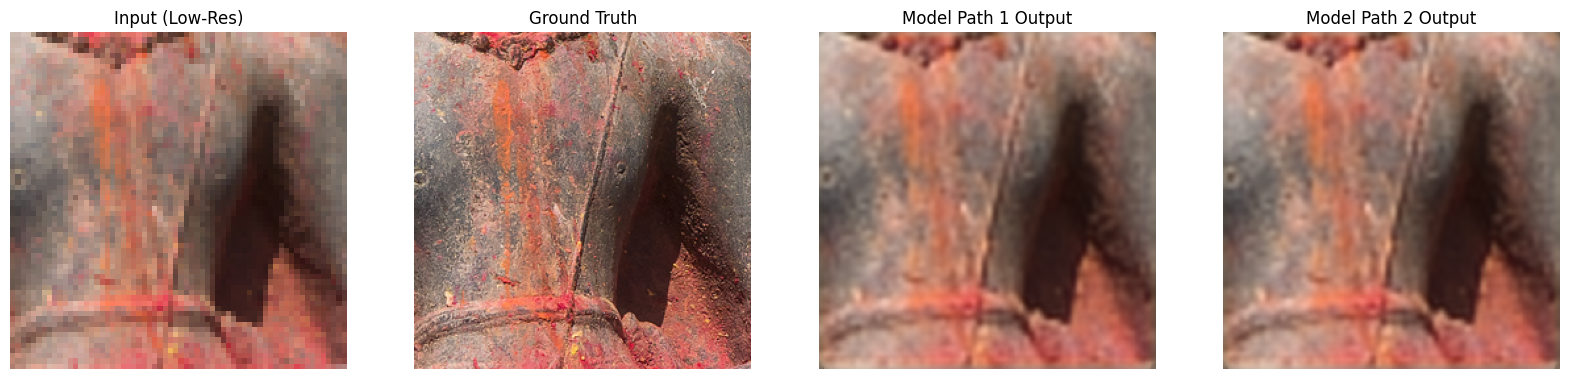

Batch 1: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


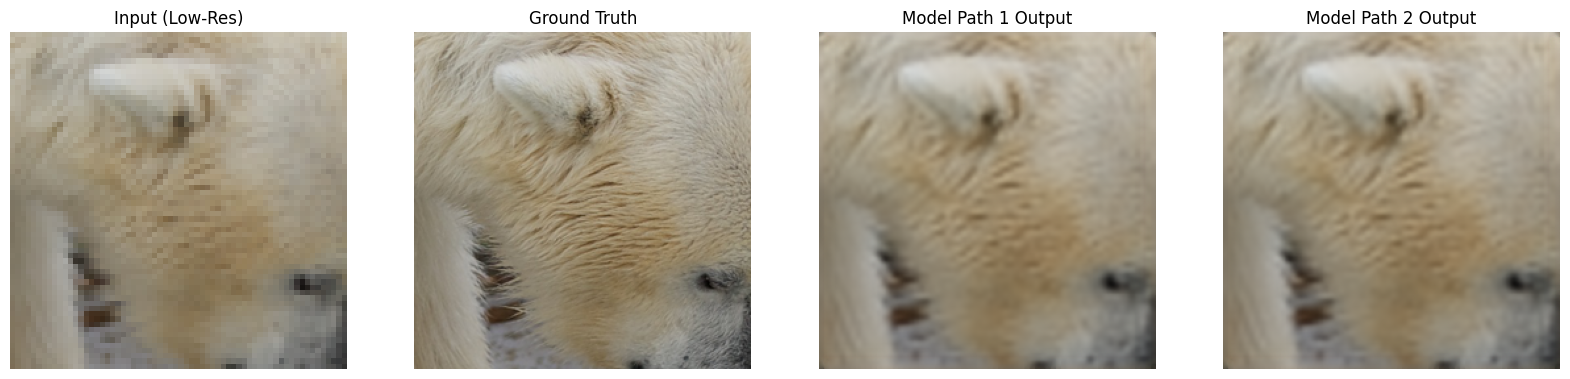

Batch 2: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006475143..1.233921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006475143..1.233921].


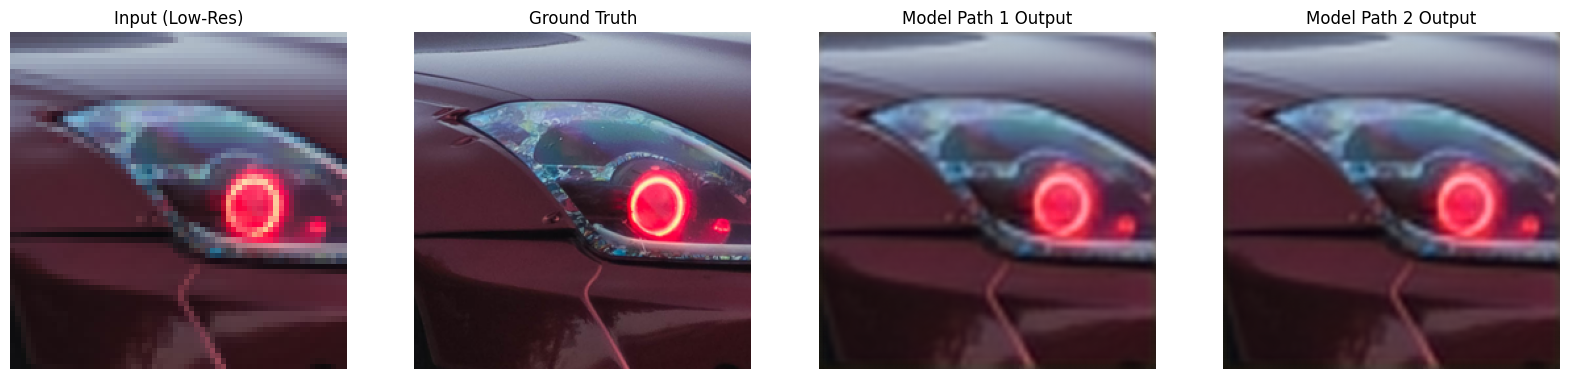

Batch 3: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


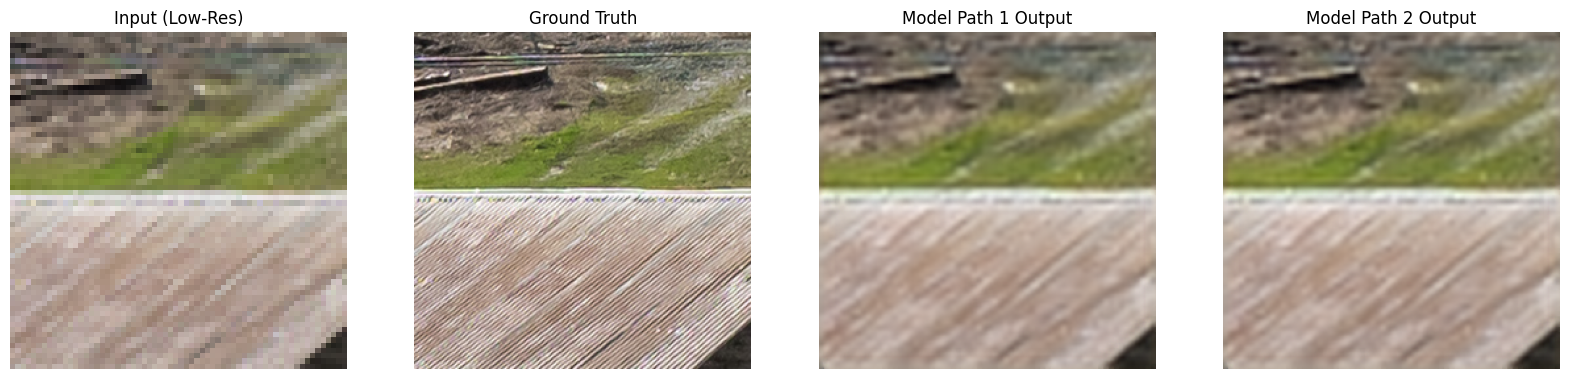

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011226853..1.0042273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011226853..1.0042273].


Batch 4: LR shape: torch.Size([2, 3, 64, 64]), HR shape: torch.Size([2, 3, 256, 256])


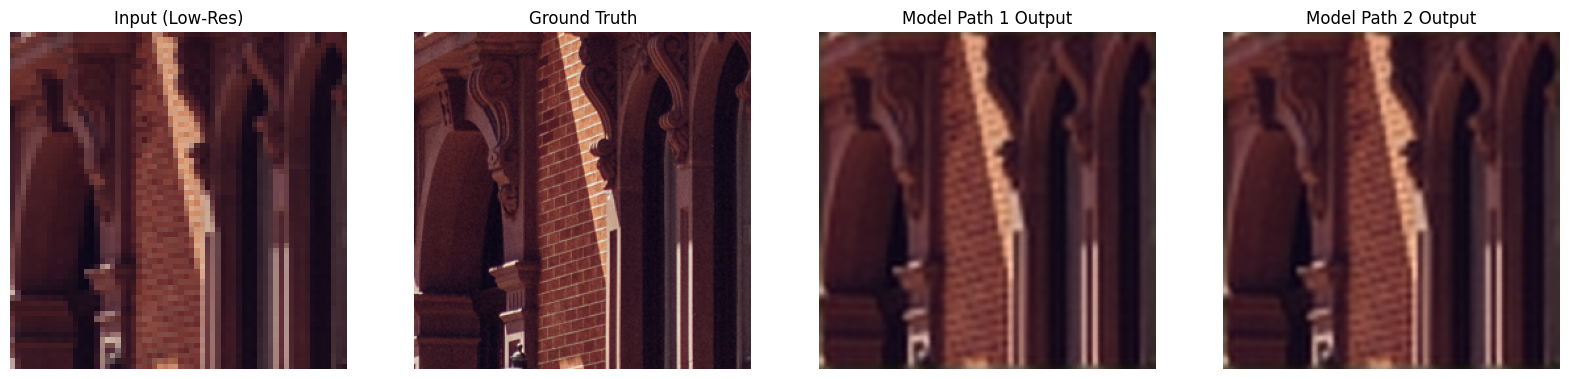

In [ ]:
# Visualize using test sr_test_loader
model_path1 = r"C:\Users\abd\d\ai\dehaze\models_1\run2\teacher_net_sr_iter_100.pth"
model_path2 = r"C:\Users\abd\d\ai\dehaze\teacher_net_sr_iter_5.pth"
# Load models
teacher_net.load_state_dict(torch.load(model_path1, map_location=device, weights_only=False), strict=False)
teacher_net1 = teacher_net
teacher_net.load_state_dict(torch.load(model_path2, map_location=device, weights_only=False), strict=False)
teacher_net2 = teacher_net

# Iterate through test loader
for i, (lr, hr) in enumerate(sr_test_loader):
    print(f"Batch {i}: LR shape: {lr.shape}, HR shape: {hr.shape}")
    lr, hr = lr.to(device), hr.to(device)
    with torch.no_grad():
        sr_out1, _, _ = teacher_net1(lr)
        sr_out2, _, _ = teacher_net2(lr)
        
        # Plot using matplotlib
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(lr[0].cpu().permute(1, 2, 0).numpy())
        axes[0].set_title("Input (Low-Res)")
        axes[0].axis("off")
        
        axes[1].imshow(hr[0].cpu().permute(1, 2, 0).numpy())
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(sr_out1[0].cpu().permute(1, 2, 0).numpy())
        axes[2].set_title("Model Path 1 Output")
        axes[2].axis("off")

        axes[3].imshow(sr_out2[0].cpu().permute(1, 2, 0).numpy())
        axes[3].set_title("Model Path 2 Output")
        axes[3].axis("off")

        plt.show()

    if i == 4:  # Just to limit the output
        break

In [ ]:
# # -----------------------------
# # LOAD TEST DATA
# # -----------------------------
# # check is exec env is local or kaggle
# if execution_env == 'kaggle':
#     test_hazy_dir = "/kaggle/input/reside6k/RESIDE-6K/test/hazy"
#     test_gt_dir = "/kaggle/input/reside6k/RESIDE-6K/test/GT"
# else:
#     test_hazy_dir = "./dehaze/dataset/RESIDE-6K/test/hazy"
#     test_gt_dir = "./dehaze/dataset/RESIDE-6K/test/GT"
#     # test_hazy_dir = "/Volumes/S/dev/project/code/Aphase/dehaze/dataset/RESIDE-6K/test/hazy"
#     # test_gt_dir = "/Volumes/S/dev/project/code/Aphase/dehaze/dataset/RESIDE-6K/test/GT"

# # test_hazy_dir = "/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN"
# # test_gt_dir = "/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT"

# hazy_images = sorted(glob.glob(os.path.join(test_hazy_dir, "*.*")))
# gt_images = sorted(glob.glob(os.path.join(test_gt_dir, "*.*")))

# transform = Compose([
#     ToTensor(),
#     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# to_pil = ToPILImage()

In [ ]:
# # -----------------------------
# # INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# # -----------------------------
# image_indices = [11, 12, 13,14]  # Indices of images to visualize

# plt.figure(figsize=(10, len(image_indices) * 5))

# for idx, i in enumerate(image_indices):
#     hazy_img = Image.open(hazy_images[i+1])
#     gt_img = Image.open(gt_images[i+1])

#     # Transform for model input
#     input_tensor = transform(hazy_img).unsqueeze(0).to(device)

#     # Inference
#     with torch.no_grad():
#         res = net(input_tensor)
#         print(res[0].shape)
#         output_tensor = res[0].cpu().squeeze(0)

#     # Convert back to image
#     output_img = to_pil(output_tensor)

#     # Display results
#     plt.subplot(len(image_indices), 3, 3 * idx + 1)
#     plt.imshow(hazy_img)
#     plt.title(f"Hazy Input ")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 2)
#     plt.imshow(output_img)
#     plt.title(f"Dehazed Output ")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 3)
#     plt.imshow(gt_img)
#     plt.title(f"Ground Truth ")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [ ]:
# # -----------------------------
# # INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# # -----------------------------
# image_indices = [70, 75, 90, 100]  # Indices of images to visualize

# plt.figure(figsize=(10, len(image_indices) * 5))

# for idx, i in enumerate(image_indices):
#     hazy_img = Image.open(hazy_images[i+1])
#     gt_img = Image.open(gt_images[i+1])

#     # Transform for model input
#     input_tensor = transform(hazy_img).unsqueeze(0).to(device)

#     # Inference
#     with torch.no_grad():
#         res = net(input_tensor)
#         print(res[0].shape)
#         output_tensor = res[0].cpu().squeeze(0)

#     # Convert back to image
#     output_img = to_pil(output_tensor)

#     # Display results
#     plt.subplot(len(image_indices), 3, 3 * idx + 1)
#     plt.imshow(hazy_img)
#     plt.title(f"Hazy Input {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 2)
#     plt.imshow(output_img)
#     plt.title(f"Dehazed Output {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 3)
#     plt.imshow(gt_img)
#     plt.title(f"Ground Truth {i}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


In [ ]:
# # -----------------------------
# # INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# # -----------------------------
# image_indices = [1, 3, 5]  # Indices of images to visualize

# plt.figure(figsize=(10, len(image_indices) * 5))

# for idx, i in enumerate(image_indices):
#     hazy_img = Image.open(hazy_images[i+1])
#     gt_img = Image.open(gt_images[i+1])

#     # Transform for model input
#     input_tensor = transform(hazy_img).unsqueeze(0).to(device)

#     # Inference
#     with torch.no_grad():
#         res = net(input_tensor)
#         print(res[0].shape)
#         output_tensor = res[0].cpu().squeeze(0)

#     # Convert back to image
#     output_img = to_pil(output_tensor)

#     # Display results
#     plt.subplot(len(image_indices), 3, 3 * idx + 1)
#     plt.imshow(hazy_img)
#     plt.title(f"Hazy Input {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 2)
#     plt.imshow(output_img)
#     plt.title(f"Dehazed Output {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 3)
#     plt.imshow(gt_img)
#     plt.title(f"Ground Truth {i}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()
